<a href="https://colab.research.google.com/github/ShinyRyo/TPU/blob/master/PyTorch_TPU_ResNet18_CIFAR10_Training_%E3%81%AE%E3%82%B3%E3%83%94%E3%83%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## PyTorch/TPU ResNet18/CIFAR10 Demo

<h3>  &nbsp;&nbsp;Use Colab Cloud TPU&nbsp;&nbsp; <a href="https://cloud.google.com/tpu/"><img valign="middle" src="https://raw.githubusercontent.com/GoogleCloudPlatform/tensorflow-without-a-phd/master/tensorflow-rl-pong/images/tpu-hexagon.png" width="50"></a></h3>

* On the main menu, click Runtime and select **Change runtime type**. Set "TPU" as the hardware accelerator.
* The cell below makes sure you have access to a TPU on Colab.


In [0]:
import os
assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook settings > Hardware accelerator'

### [RUNME] Install Colab TPU compatible PyTorch/TPU wheels and dependencies
This may take up to ~2 minutes



In [0]:
VERSION = "20200516"  #@param ["1.5" , "20200516", "nightly"]
!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
!python pytorch-xla-env-setup.py --version $VERSION

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4264  100  4264    0     0  23048      0 --:--:-- --:--:-- --:--:-- 22924
Updating TPU and VM. This may take around 2 minutes.
Updating TPU runtime to pytorch-dev20200516 ...
Uninstalling torch-1.5.0+cu101:
Done updating TPU runtime: <Response [200]>
  Successfully uninstalled torch-1.5.0+cu101
Uninstalling torchvision-0.6.0+cu101:
  Successfully uninstalled torchvision-0.6.0+cu101
Copying gs://tpu-pytorch/wheels/torch-nightly+20200516-cp36-cp36m-linux_x86_64.whl...
- [1 files][ 91.0 MiB/ 91.0 MiB]                                                
Operation completed over 1 objects/91.0 MiB.                                     
Copying gs://tpu-pytorch/wheels/torch_xla-nightly+20200516-cp36-cp36m-linux_x86_64.whl...
- [1 files][119.8 MiB/119.8 MiB]                                                
Operation completed over 1 objec

### Define Parameters



In [0]:
# Result Visualization Helper
from matplotlib import pyplot as plt

M, N = 4, 6
RESULT_IMG_PATH = '/tmp/test_result.jpg'
CIFAR10_LABELS = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                 'dog', 'frog', 'horse', 'ship', 'truck']

def plot_results(images, labels, preds):
  images, labels, preds = images[:M*N], labels[:M*N], preds[:M*N]
  inv_norm = transforms.Normalize(
      mean=(-0.4914/0.2023, -0.4822/0.1994, -0.4465/0.2010),
      std=(1/0.2023, 1/0.1994, 1/0.2010))

  num_images = images.shape[0]
  fig, axes = plt.subplots(M, N, figsize=(16, 9))
  fig.suptitle('Correct / Predicted Labels (Red text for incorrect ones)')

  for i, ax in enumerate(fig.axes):
    ax.axis('off')
    if i >= num_images:
      continue
    img, label, prediction = images[i], labels[i], preds[i]
    img = inv_norm(img)
    img = img.permute(1, 2, 0) # (C, M, N) -> (M, N, C)
    label, prediction = label.item(), prediction.item()
    if label == prediction:
      ax.set_title(u'\u2713', color='blue', fontsize=22)
    else:
      ax.set_title(
          'X {}/{}'.format(CIFAR10_LABELS[label],
                          CIFAR10_LABELS[prediction]), color='red')
    ax.imshow(img)
  plt.savefig(RESULT_IMG_PATH, transparent=True)

In [0]:
# Define Parameters
FLAGS = {}
FLAGS['data_dir'] = "/tmp/cifar"
FLAGS['batch_size'] = 128
FLAGS['num_workers'] = 4
FLAGS['learning_rate'] = 0.02
FLAGS['momentum'] = 0.9
FLAGS['num_epochs'] = 20
FLAGS['num_cores'] = 8
FLAGS['log_steps'] = 20
FLAGS['metrics_debug'] = False

In [0]:
import numpy as np
import os
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch_xla
import torch_xla.core.xla_model as xm
import torch_xla.debug.metrics as met
import torch_xla.distributed.parallel_loader as pl
import torch_xla.distributed.xla_multiprocessing as xmp
import torch_xla.utils.utils as xu
import torchvision
from torchvision import datasets, transforms

class BasicBlock(nn.Module):
  expansion = 1

  def __init__(self, in_planes, planes, stride=1):
    super(BasicBlock, self).__init__()
    self.conv1 = nn.Conv2d(
        in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(planes)
    self.conv2 = nn.Conv2d(
        planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(planes)

    self.shortcut = nn.Sequential()
    if stride != 1 or in_planes != self.expansion * planes:
      self.shortcut = nn.Sequential(
          nn.Conv2d(
              in_planes,
              self.expansion * planes,
              kernel_size=1,
              stride=stride,
              bias=False), nn.BatchNorm2d(self.expansion * planes))

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.bn2(self.conv2(out))
    out += self.shortcut(x)
    out = F.relu(out)
    return out


class ResNet(nn.Module):

  def __init__(self, block, num_blocks, num_classes=10):
    super(ResNet, self).__init__()
    self.in_planes = 64

    self.conv1 = nn.Conv2d(
        3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(64)
    self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
    self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
    self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
    self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
    self.linear = nn.Linear(512 * block.expansion, num_classes)

  def _make_layer(self, block, planes, num_blocks, stride):
    strides = [stride] + [1] * (num_blocks - 1)
    layers = []
    for stride in strides:
      layers.append(block(self.in_planes, planes, stride))
      self.in_planes = planes * block.expansion
    return nn.Sequential(*layers)

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.layer1(out)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    out = F.avg_pool2d(out, 4)
    out = torch.flatten(out, 1)
    out = self.linear(out)
    return F.log_softmax(out, dim=1)


def ResNet18():
  return ResNet(BasicBlock, [2, 2, 2, 2])

In [0]:
SERIAL_EXEC = xmp.MpSerialExecutor()
# Only instantiate model weights once in memory.
WRAPPED_MODEL = xmp.MpModelWrapper(ResNet18())

def train_resnet18():
  torch.manual_seed(1)

  def get_dataset():
    norm = transforms.Normalize(
        mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        norm,
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        norm,
    ])
    train_dataset = datasets.CIFAR10(
        root=FLAGS['data_dir'],
        train=True,
        download=True,
        transform=transform_train)
    test_dataset = datasets.CIFAR10(
        root=FLAGS['data_dir'],
        train=False,
        download=True,
        transform=transform_test)
    
    return train_dataset, test_dataset
  
  # Using the serial executor avoids multiple processes
  # to download the same data.
  train_dataset, test_dataset = SERIAL_EXEC.run(get_dataset)

  train_sampler = torch.utils.data.distributed.DistributedSampler(
      train_dataset,
      num_replicas=xm.xrt_world_size(),
      rank=xm.get_ordinal(),
      shuffle=True)
  train_loader = torch.utils.data.DataLoader(
      train_dataset,
      batch_size=FLAGS['batch_size'],
      sampler=train_sampler,
      num_workers=FLAGS['num_workers'],
      drop_last=True)
  test_loader = torch.utils.data.DataLoader(
      test_dataset,
      batch_size=FLAGS['batch_size'],
      shuffle=False,
      num_workers=FLAGS['num_workers'],
      drop_last=True)

  # Scale learning rate to num cores
  learning_rate = FLAGS['learning_rate'] * xm.xrt_world_size()

  # Get loss function, optimizer, and model
  device = xm.xla_device()
  model = WRAPPED_MODEL.to(device)
  optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                        momentum=FLAGS['momentum'], weight_decay=5e-4)
  loss_fn = nn.NLLLoss()

  def train_loop_fn(loader):
    tracker = xm.RateTracker()
    model.train()
    for x, (data, target) in enumerate(loader):
      optimizer.zero_grad()
      output = model(data)
      loss = loss_fn(output, target)
      loss.backward()
      xm.optimizer_step(optimizer)
      tracker.add(FLAGS['batch_size'])
      if x % FLAGS['log_steps'] == 0:
        print('[xla:{}]({}) Loss={:.5f} Rate={:.2f} GlobalRate={:.2f} Time={}'.format(
            xm.get_ordinal(), x, loss.item(), tracker.rate(),
            tracker.global_rate(), time.asctime()), flush=True)

  def test_loop_fn(loader):
    total_samples = 0
    correct = 0
    model.eval()
    data, pred, target = None, None, None
    for data, target in loader:
      output = model(data)
      pred = output.max(1, keepdim=True)[1]
      correct += pred.eq(target.view_as(pred)).sum().item()
      total_samples += data.size()[0]

    accuracy = 100.0 * correct / total_samples
    print('[xla:{}] Accuracy={:.2f}%'.format(
        xm.get_ordinal(), accuracy), flush=True)
    return accuracy, data, pred, target

  # Train and eval loops
  accuracy = 0.0
  data, pred, target = None, None, None
  for epoch in range(1, FLAGS['num_epochs'] + 1):
    para_loader = pl.ParallelLoader(train_loader, [device])
    train_loop_fn(para_loader.per_device_loader(device))
    xm.master_print("Finished training epoch {}".format(epoch))

    para_loader = pl.ParallelLoader(test_loader, [device])
    accuracy, data, pred, target  = test_loop_fn(para_loader.per_device_loader(device))
    if FLAGS['metrics_debug']:
      xm.master_print(met.metrics_report(), flush=True)

  return accuracy, data, pred, target
  

In [0]:
# Start training processes
def _mp_fn(rank, flags):
  global FLAGS
  FLAGS = flags
  torch.set_default_tensor_type('torch.FloatTensor')
  accuracy, data, pred, target = train_resnet18()
  if rank == 0:
    # Retrieve tensors that are on TPU core 0 and plot.
    plot_results(data.cpu(), pred.cpu(), target.cpu())

xmp.spawn(_mp_fn, args=(FLAGS,), nprocs=FLAGS['num_cores'],
          start_method='fork')

Extracting /tmp/cifar/cifar-10-python.tar.gz to /tmp/cifar
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
[xla:0](0) Loss=2.32398 Rate=52.36 GlobalRate=52.36 Time=Tue Jun  2 03:51:56 2020
[xla:5](0) Loss=2.37052 Rate=279.37 GlobalRate=279.35 Time=Tue Jun  2 03:51:57 2020
Files already downloaded and verified
Files already downloaded and verified
[xla:6](0) Loss=2.33233 Rate=253.21 GlobalRate=253.20 Time=Tue Jun  2 03:51:59 2020
Files already downloaded and verified
Files already downloaded and verified
[xla:7](0) Loss=2.34590 Rate=266.28 GlobalRate=266.27 Time=Tue Jun  2 03:52:01 2020
Files already downloaded and verified
Files already downloaded and verified
[xla:2](0) Loss=2.33303 Rate=270.24 GlobalRate=270.23 Time=Tue Jun  2 03:52:03 2020
Files already downloaded and verified
Files already downloaded and verified
[xla:3](0) Loss=2.39517 Rate=263.24 GlobalRate=263.21 Time=Tue Jun 

## Visualize Predictions

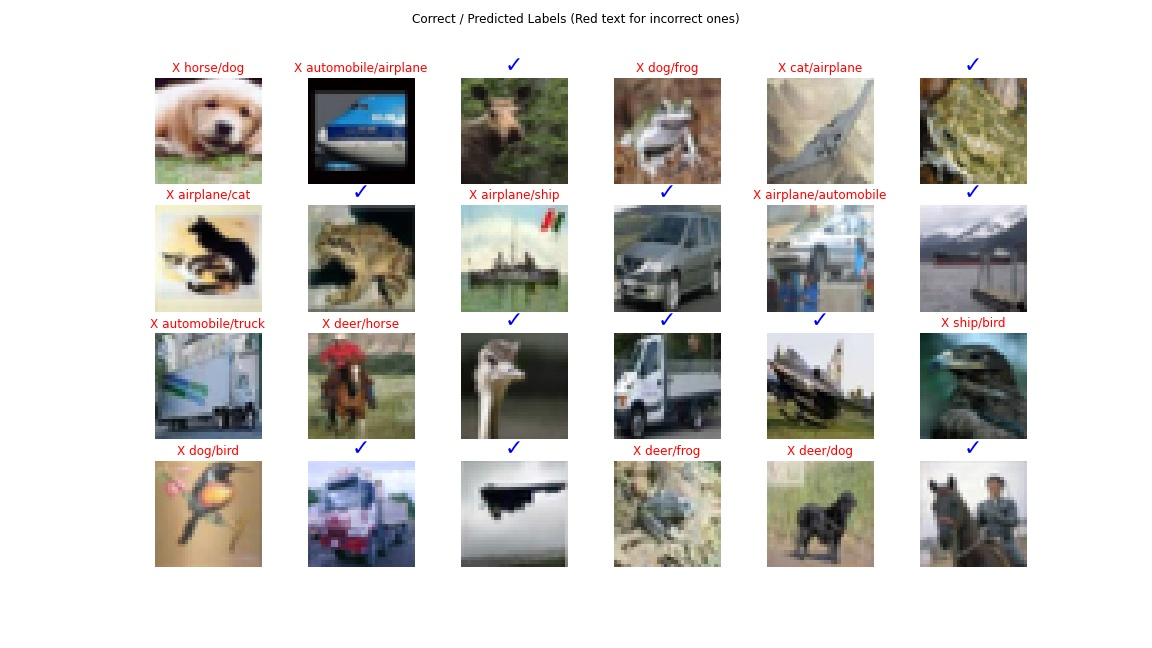

In [0]:
from google.colab.patches import cv2_imshow
import cv2
img = cv2.imread(RESULT_IMG_PATH, cv2.IMREAD_UNCHANGED)
cv2_imshow(img)